In [1]:
import os
import bokeh
from bokeh.plotting import show
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phenograph
import pacmap
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import flowkit as fk

bokeh.io.output_notebook()
%matplotlib inline

Loading BokehJS ...

### Load Samples & FlowJo 10 workspace

In [2]:
base_dir = "data/8_color_data_set/"
sample_path = os.path.join(base_dir, "fcs_files")
wsp_path = os.path.join(base_dir, "8_color_ICS.wsp")

seed = 123

In [3]:
session = fk.Session(sample_path)
session.import_flowjo_workspace(wsp_path)

In [4]:
sample_groups = session.get_sample_groups()
sample_groups

['default', 'All Samples', 'DEN']

In [5]:
sample_group = sample_groups[-1]

In [6]:
print(session.get_gate_hierarchy(sample_group, output='ascii'))

root
╰── Time
    ╰── Singlets
        ╰── aAmine-
            ╰── CD3+
                ├── CD4+
                │   ├── CD107a+
                │   ├── IFNg+
                │   ├── IL2+
                │   ╰── TNFa+
                ╰── CD8+
                    ├── CD107a+
                    ├── IFNg+
                    ├── IL2+
                    ╰── TNFa+


In [7]:
sample_ids = session.get_sample_ids()
sample_ids

['101_DEN084Y5_15_E03_009_clean.fcs',
 '101_DEN084Y5_15_E01_008_clean.fcs',
 '101_DEN084Y5_15_E05_010_clean.fcs']

### Run analyze_samples & retrieve gated events as DataFrames

In [8]:
session.analyze_samples(sample_group)

In [9]:
dfs = session.get_wsp_gated_events(sample_group, gate_id="Singlets")

In [10]:
dfs[0].head()

,sample_group,sample_id,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W,TNFa FITC FLR-A,CD8 PerCP-Cy55 FLR-A,IL2 BV421 FLR-A,Aqua Amine FLR-A,IFNg APC FLR-A,CD3 APC-H7 FLR-A,CD107a PE FLR-A,CD4 PE-Cy7 FLR-A,Time
444,DEN,101_DEN084Y5_15_E05_010_clean.fcs,0.605266,0.534996,0.282837,0.112971,0.112389,0.251296,0.239269,0.481516,0.264009,0.248319,0.229839,0.379135,0.255063,0.219829,0.034859
445,DEN,101_DEN084Y5_15_E05_010_clean.fcs,0.406262,0.359482,0.282533,0.135675,0.131271,0.258386,0.235978,0.290715,0.294722,0.248319,0.260612,0.510475,0.256589,0.594417,0.034874
446,DEN,101_DEN084Y5_15_E05_010_clean.fcs,0.290651,0.237827,0.305527,0.225677,0.218296,0.258453,0.252083,0.307089,0.441976,0.542595,0.231741,0.437376,0.325715,0.301048,0.034874
447,DEN,101_DEN084Y5_15_E05_010_clean.fcs,0.539687,0.395210,0.341392,0.319373,0.281456,0.283679,0.254682,0.314314,0.349194,0.285559,0.265933,0.293000,0.512644,0.324284,0.034889
451,DEN,101_DEN084Y5_15_E05_010_clean.fcs,0.700945,0.568222,0.308394,0.164359,0.155502,0.264239,0.256816,0.253237,0.230823,0.259114,0.236539,0.392527,0.294711,0.595406,0.034904


In [11]:
k = 10_000
X = pd.concat([df.iloc[:, 2:-1].sample(k) for df in dfs])

In [12]:
X.head()

,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W,TNFa FITC FLR-A,CD8 PerCP-Cy55 FLR-A,IL2 BV421 FLR-A,Aqua Amine FLR-A,IFNg APC FLR-A,CD3 APC-H7 FLR-A,CD107a PE FLR-A,CD4 PE-Cy7 FLR-A
152170,0.447325,0.360264,0.310415,0.136185,0.130711,0.260470,0.248788,0.592350,0.295164,0.225845,0.238052,0.514365,0.260100,0.364846
31774,0.726931,0.634007,0.286642,0.090003,0.088062,0.255508,0.237793,0.569430,0.267490,0.243838,0.232563,0.272503,0.250091,0.236781
227567,0.549948,0.425663,0.322995,0.554988,0.467838,0.296570,0.507559,0.303195,0.410499,0.309523,0.274543,0.274663,0.464391,0.290409
217003,0.322233,0.240753,0.334610,0.389095,0.345306,0.281703,0.350988,0.391528,0.566020,0.648565,0.264724,0.202302,0.638162,0.308004
38710,0.515382,0.408894,0.315107,0.175184,0.166584,0.262907,0.251745,0.685544,0.294500,0.243366,0.261280,0.494248,0.272537,0.305092


### Perform Louvain & Leiden clustering

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [14]:
communities_louvain, graph_louvain, Q_louvain = phenograph.cluster(
    X_scaled, 
    clustering_algo='louvain', 
    seed=seed
)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 8.269416809082031 seconds
Jaccard graph constructed in 2.0473647117614746 seconds
Wrote graph to binary file in 0.5302481651306152 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.856236
Louvain completed 21 runs in 28.202480792999268 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 39.45203518867493 seconds


In [15]:
communities_leiden, graph_leiden, Q_leiden = phenograph.cluster(
    X_scaled, 
    clustering_algo='leiden',
    seed=seed
)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 9.195850372314453 seconds
Jaccard graph constructed in 1.9538328647613525 seconds
Running Leiden optimization
Leiden completed in 4.502513408660889 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 16.84879469871521 seconds


In [16]:
titles = ['Leiden', 'Louvain']
communities = [communities_leiden, communities_louvain]

In [17]:
leiden_means = [
    X_scaled[communities_leiden==i, :].mean(axis=0)
    for i in np.unique(communities_leiden)
]
leiden_clusters = pd.DataFrame(
    leiden_means, 
    columns = X.columns, 
    index=np.unique(communities_leiden)
)
leiden_clusters.index.name = 'Cluster'

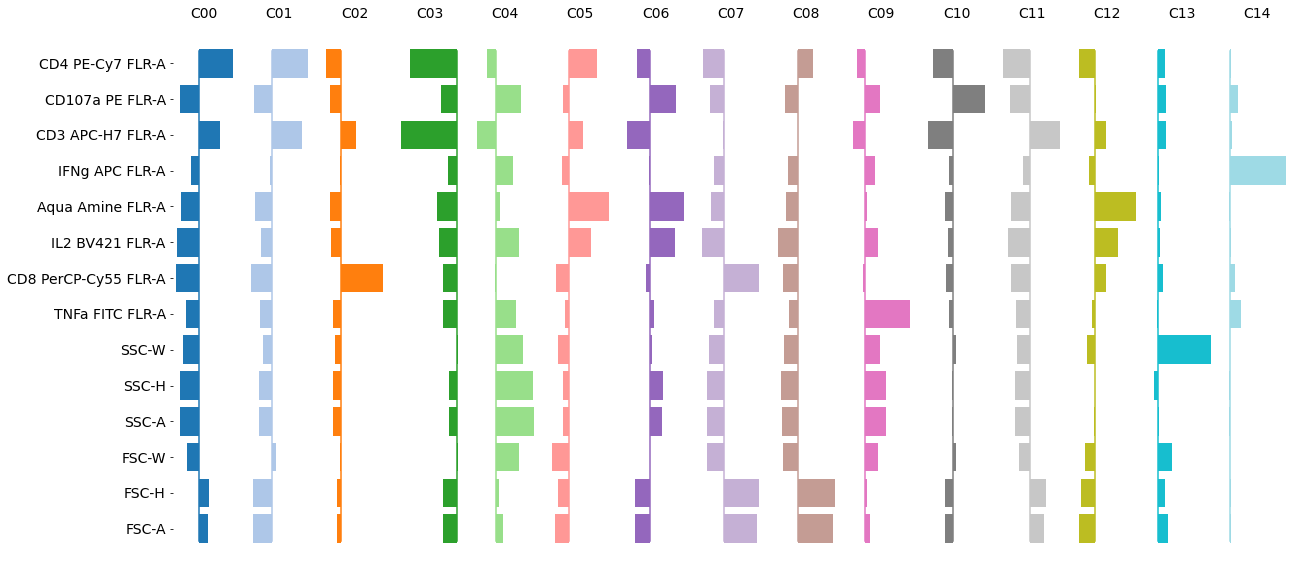

In [18]:
tab20 = plt.cm.get_cmap('tab20')
n, p = leiden_clusters.shape

fig, axes = plt.subplots(1, n, figsize=(20, 10))

for i, ax in enumerate(axes.ravel()):
    ax.barh(range(p), leiden_clusters.iloc[i,:], color=tab20(int(i*(20+1)/n)))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    ax.set_title(f'C{i:02d}', fontsize=14)
    ax.axvline(0, c=tab20(int(i*(20+1)/n)), ymin=0.05, ymax=0.95)
    
    if i == 0:
        ax.set_yticks(range(p))
        ax.set_yticklabels(leiden_clusters.columns,fontsize=14)

### Apply dimension reduction using PaCMAP

In [19]:
embedder = pacmap.PaCMAP()

In [20]:
X2 = embedder.fit_transform(X_scaled)

In [21]:
min_max_scaler = MinMaxScaler()
X2 = min_max_scaler.fit_transform(X2)

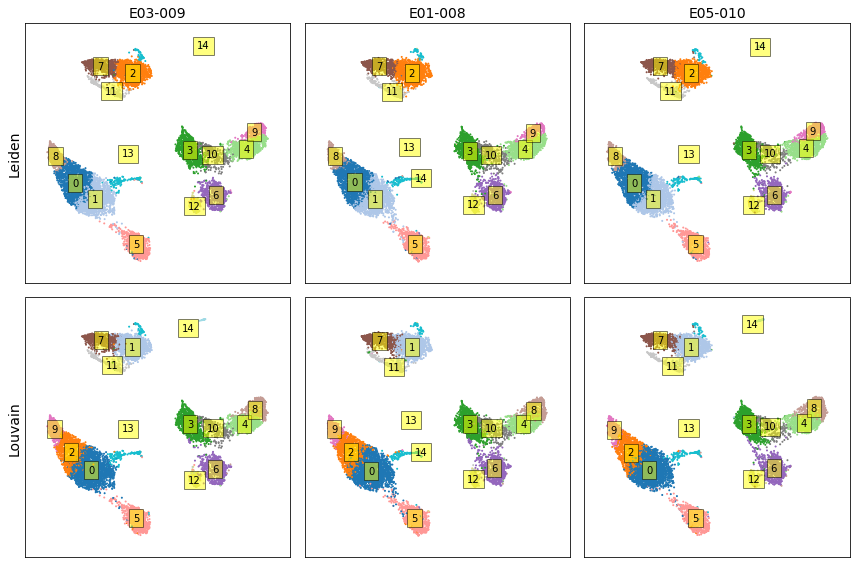

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, (community, title) in enumerate(zip(communities, titles)):
    for j in range(3):
        z = community[(j*k):(j+1)*k]
        x = X2[(j*k):(j+1)*k, 0]
        y = X2[(j*k):(j+1)*k, 1]
        
        ax = axes[i, j]
        ax.scatter(x, y, s=1, c=z, cmap='tab20')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim([-0.1,1.1])
        ax.set_ylim([-0.1,1.1])
        if j==0:
            ax.set_ylabel(title, fontsize=14)
        if i==0:
            ax.set_title('-'.join(sample_ids[j].split('_')[3:5]), fontsize=14)
            
        for idx in np.unique(z):
            x_, y_ = x[z==idx], y[z==idx]
            x_c, y_c = np.mean(x_), np.mean(y_)
            
            ax.text(
                x_c, 
                y_c, 
                str(idx), 
                va='center', 
                ha='center', 
                bbox=dict(fc='yellow', alpha=0.5)
            )
            
plt.tight_layout()